In [7]:
import pandas as pd
import numpy as np
from contextlib import contextmanager
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
import autosklearn.classification
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve,plot_precision_recall_curve, average_precision_score
from sklearn import svm, manifold, decomposition, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, plot_confusion_matrix, average_precision_score, accuracy_score, f1_score
from tqdm import tqdm
import lime

In [2]:
df = pd.read_csv ('./data/standardized_data_2.csv')
print(df.shape)

(1613, 1666)


In [3]:
df = df.drop(['age.1','dx.1','group.1','age.2','dx.2','group.2','age.3','dx.3','group.3','age.4','dx.4','group.4','age.5','dx.5','group.5',
         'age.6','dx.6','group.6','age.7','dx.7','group.7','age.8','dx.8','group.8','age.9','dx.9','group.9','age.10','dx.10','group.10',
         'age.11','dx.11','group.11','age.12','dx.12','group.12','age.13','dx.13','group.13','age.14','dx.14','group.14','age.15','dx.15','group.15',
         'age.16','dx.16','group.16','age.17','dx.17','group.17','age.18','dx.18','group.18','age.19','dx.19','group.19','age.20','dx.20','group.20',
         'age.21','dx.21','group.21','age.22','dx.22','group.22','age.23','dx.23','group.23','age.24','dx.24','group.24','age.25','dx.25','group.25',
         'age.26','dx.26','group.26','age.27','dx.27','group.27','age.28','dx.28','group.28','age.29','dx.29','group.29','age.30','dx.30','group.30',
         'age.31','dx.31','group.31','age.32','dx.32','group.32','age.33','dx.33','group.33','age.34','dx.34','group.34','age.35','dx.35','group.35',
         'age.36','dx.36','group.36','age.37','dx.37','group.37','age.38','dx.38','group.38','age.39','dx.39','group.39','age.40','dx.40','group.40',
         'age.41','dx.41','group.41','age.42','dx.42','group.42','age.43','dx.43','group.43','age.44','dx.44','group.44','age.45','dx.45','group.45',
         'age.46','dx.46','group.46','age.47','dx.47','group.47','age.48','dx.48','group.48'], axis=1)

print(df.shape)

(1613, 1522)


In [4]:
train_og = pd.DataFrame(df[df["group"] == "train"]).copy()
test_og = pd.DataFrame(df[df["group"] == "test"]).copy()

y_train_og = pd.DataFrame(train_og["dx"])
y_train_og.loc[(train_og['dx'] == 1)] = 0
y_train_og.loc[(train_og['dx'] == 2)] = 1
y_test_og = pd.DataFrame(test_og["dx"])
y_test_og.loc[(test_og['dx'] == 1)] = 0
y_test_og.loc[(test_og['dx'] == 2)] = 1
x_train_og = train_og.drop(['dx', 'age', 'group'], axis=1)
x_test_og = test_og.drop(['dx', 'age', 'group'], axis=1)

y_full_og = (pd.concat([y_train_og, y_test_og], axis=0))
x_full_og = (pd.concat([x_train_og, x_test_og], axis=0))

print(y_full_og.shape)
print(x_full_og.shape)

(1613, 1)
(1613, 1519)


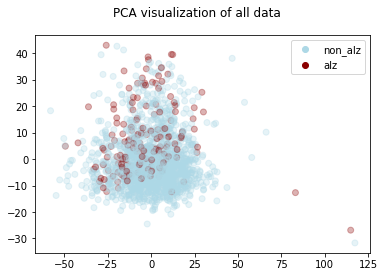

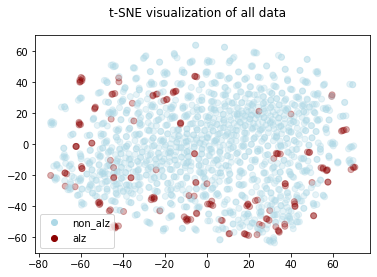

In [5]:
#print('Computing PCA Embedding')
pca = decomposition.PCA(n_components=2)
pca.fit(x_full_og)
Y = pca.transform(x_full_og)
colors = ['lightblue' if (i == 0) else 'darkred' for i in y_full_og.values]
fig = plt.figure(1)
fig.suptitle('PCA visualization of all data')
ax = fig.add_subplot(111)
ax.scatter(Y[:, 0], Y[:, 1], c=colors, alpha=0.3)
m1, = plt.plot(np.nan, np.nan, c='lightblue', linestyle='None', marker='o', label='non_alz', alpha=1)
m2, = plt.plot(np.nan, np.nan, c='darkred', linestyle='None', marker='o', label="alz", alpha=1)
plt.legend(handles=[m1, m2], loc='best')
plt.show()
#plt.savefig('./pca.png', dpi=300)
#plt.close()

#print('Computing t-SNE Embedding')
tsne = manifold.TSNE(n_components=2, init='pca', random_state=726, n_iter=1500)
Y = tsne.fit_transform(x_full_og)

colors = ['lightblue' if (i == 0) else 'darkred' for i in y_full_og.values]
fig = plt.figure(2)
fig.suptitle('t-SNE visualization of all data')
ax = fig.add_subplot(111)
ax.scatter(Y[:, 0], Y[:, 1], c=colors, alpha=0.3)
m1, = plt.plot(np.nan, np.nan, c='lightblue', linestyle='None', marker='o', label='non_alz', alpha=1)
m2, = plt.plot(np.nan, np.nan, c='darkred', linestyle='None', marker='o', label='alz', alpha=1)
plt.legend(handles=[m1, m2], loc='best')
plt.show()
#plt.savefig('./tsne.png', dpi=300)
#plt.close()

In [13]:
kf = StratifiedKFold(n_splits=10, shuffle=True)
X = x_train_og
y = y_train_og

# Logistic Regression Classification Model ---
mod_lgrg = LogisticRegression(max_iter=100000,solver="sag", random_state = 726)

# Support Vector Classification Model --- 
mod_svc  = svm.SVC(random_state=726, kernel='linear' ,probability = True,break_ties=True)

# Random Forest Classification Model ---
mod_rfc = RandomForestClassifier(random_state=726, max_features=0.2) 

# Multi-Layer Perceptron Classification Model ---
mod_mlp = MLPClassifier(random_state=726, activation = "tanh", alpha=0.0005, hidden_layer_sizes=(150,), learning_rate = "adaptive")

# Gradient Boosted Tree Classification Model ---
mod_gbt = GradientBoostingClassifier(random_state=726, n_estimators=80, learning_rate=1, max_features=3, max_depth=3)

# AdaBoost Classification Model ---
mod_abc = AdaBoostClassifier(random_state=726, n_estimators=50,learning_rate=1.1)

valid_acc_lgrg, valid_acc_svc, valid_acc_rfc, valid_acc_mlp, valid_acc_gbt, valid_acc_abc = [],[],[],[],[],[]
valid_f1s_lgrg, valid_f1s_svc, valid_f1s_rfc, valid_f1s_mlp, valid_f1s_gbt, valid_acc_abc = [],[],[],[],[],[]

for train_ix, validation_ix in tqdm(kf.split(X,y),total=10):
    X_train, X_validation = X.iloc[train_ix], X.iloc[validation_ix]
    y_train, y_validation = y.iloc[train_ix], y.iloc[validation_ix]
    
    mod_lgrg.fit(X_train, y_train.to_numpy().ravel())
    pred_train_lgrg = mod_lgrg.predict(X_train)
    pred_validation_lgrg = mod_lgrg.predict(X_validation)
    train_acc_lgrg = accuracy_score(y_train, pred_train_lgrg)
    validation_acc_lgrg = accuracy_score(y_validation, pred_validation_lgrg)
    validation_f1s_lgrg = f1_score(y_validation, pred_validation_lgrg)

    mod_svc.fit(X_train, y_train.to_numpy().ravel())
    pred_train_svc = mod_svc.predict(X_train)
    pred_validation_svc = mod_svc.predict(X_validation)
    train_acc_svc = accuracy_score(y_train, pred_train_svc)
    validation_acc_svc = accuracy_score(y_validation, pred_validation_svc)
    validation_f1s_svc = f1_score(y_validation, pred_validation_svc)

    mod_rfc.fit(X_train, y_train.to_numpy().ravel())
    pred_train_rfc = mod_rfc.predict(X_train)
    pred_validation_rfc = mod_rfc.predict(X_validation)
    train_acc_rfc = accuracy_score(y_train, pred_train_rfc)
    validation_acc_rfc = accuracy_score(y_validation, pred_validation_rfc)
    validation_f1s_rfc = f1_score(y_validation, pred_validation_rfc)
    
    mod_mlp.fit(X_train, y_train.to_numpy().ravel())
    pred_train_mlp = mod_mlp.predict(X_train)
    pred_validation_mlp = mod_mlp.predict(X_validation)
    train_acc_mlp = accuracy_score(y_train, pred_train_mlp)
    validation_acc_mlp = accuracy_score(y_validation, pred_validation_mlp)
    validation_f1s_mlp = f1_score(y_validation, pred_validation_mlp)
    
    mod_gbt.fit(X_train, y_train.to_numpy().ravel())
    pred_train_gbt = mod_gbt.predict(X_train)
    pred_validation_gbt = mod_gbt.predict(X_validation)
    train_acc_gbt = accuracy_score(y_train, pred_train_gbt)
    validation_acc_gbt = accuracy_score(y_validation, pred_validation_gbt)
    validation_f1s_gbt = f1_score(y_validation, pred_validation_gbt)
    
    mod_abc.fit(X_train, y_train.to_numpy().ravel())
    pred_train_abc = mod_abc.predict(X_train)
    pred_validation_abc = mod_abc.predict(X_validation)
    train_acc_abc = accuracy_score(y_train, pred_train_abc)
    validation_acc_abc = accuracy_score(y_validation, pred_validation_abc)
    validation_f1s_abc = f1_score(y_validation, pred_validation_abc)

#     lr_probs_scv = mod_mlp.predict_proba(X_validation)
#     lr_probs_scv = lr_probs_scv[:, 1]

#     average_precision = average_precision_score(y_validation, lr_probs_scv)
#     avg_perc.append(average_precision)
    
#     print(confusion_matrix(y_validation, mod_mlp.predict(X_validation)))
    # plot_confusion_matrix(clf, X_train, y_train,cmap='GnBu',values_format='.4g')
    # plot_confusion_matrix(clf, X_train, y_train,cmap='GnBu',values_format='.4g',normalize='true')
    # plot_confusion_matrix(clf, X_validation, y_validation,cmap='GnBu',values_format='.4g')
    
    valid_acc_lgrg.append(validation_acc_lgrg)
    valid_acc_svc.append(validation_acc_svc)
    valid_acc_rfc.append(validation_acc_rfc)
    valid_acc_mlp.append(validation_acc_mlp)
    valid_acc_gbt.append(validation_acc_gbt)
    valid_acc_abc.append(validation_acc_abc)
    
    valid_f1s_lgrg.append(validation_f1s_lgrg)
    valid_f1s_svc.append(validation_f1s_svc)
    valid_f1s_rfc.append(validation_f1s_rfc)
    valid_f1s_mlp.append(validation_f1s_mlp)
    valid_f1s_gbt.append(validation_f1s_gbt)
    valid_f1s_abc.append(validation_f1s_abc)
# print(np.mean(validation_acc_array))
# print(validation_acc_array)
# print(np.mean(avg_perc))

mod_lgrg.fit(x_train_og, y_train_og.to_numpy().ravel())
mod_svc.fit(x_train_og, y_train_og.to_numpy().ravel())
mod_rfc.fit(x_train_og, y_train_og.to_numpy().ravel())
mod_mlp.fit(x_train_og, y_train_og.to_numpy().ravel())
mod_gbt.fit(x_train_og, y_train_og.to_numpy().ravel())
mod_abc.fit(x_train_og, y_train_og.to_numpy().ravel())

100%|██████████| 10/10 [15:14<00:00, 91.50s/it]


AdaBoostClassifier(learning_rate=1.1, random_state=726)

In [11]:
X = x_train_og
y = y_train_og
mod_asc = autosklearn.classification.AutoSklearnClassifier()
mod_asc.fit(x_train_og, y_train_og)

AutoSklearnClassifier(per_run_time_limit=360)

In [ ]:
mod_asc

In [10]:
kf = StratifiedKFold(n_splits=10, shuffle=True)
X = x_train_og
y = y_train_og

lr_list = [0]
#mod_gbt = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    
valid_acc_asc_fin = []
valid_f1s_asc_fin = []

#abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)

for learning_rate in lr_list:
    valid_acc_abc = []
    valid_f1s_abc = []

    mod_asc = autosklearn.classification.AutoSklearnClassifier()
    
    for train_ix, validation_ix in tqdm(kf.split(X,y),total=10):
        X_train, X_validation = X.iloc[train_ix], X.iloc[validation_ix]
        y_train, y_validation = y.iloc[train_ix], y.iloc[validation_ix]
    
        mod_asc.fit(X_train, y_train.to_numpy().ravel())
        pred_train_asc = mod_asc.predict(X_train)
        pred_validation_asc = mod_asc.predict(X_validation)
        train_acc_asc = accuracy_score(y_train, pred_train_asc)
        validation_acc_asc = accuracy_score(y_validation, pred_validation_asc)
        validation_f1s_asc = f1_score(y_validation, pred_validation_asc)
    
        valid_acc_asc.append(validation_acc_asc)
    
        valid_f1s_asc.append(validation_f1s_asc)
    
    mod_asc.fit(x_train_og, y_train_og.to_numpy().ravel())

    print("Learning rate: ", learning_rate)
    print("valid acc: {0:.3f}".format(np.mean(valid_acc_asc)))
    print("valid f1: {0:.3f}".format(np.mean(valid_f1s_asc)))
    print(confusion_matrix(y_test_og, mod_asc.predict(x_test_og)))
    
#     print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
#     print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_val, y_val)))

#mod_lgrg.fit(x_train_og, y_train_og.to_numpy().ravel())

# ----------

#     lr_probs_scv = mod_mlp.predict_proba(X_validation)
#     lr_probs_scv = lr_probs_scv[:, 1]

#     average_precision = average_precision_score(y_validation, lr_probs_scv)
#     avg_perc.append(average_precision)
    
#     print(confusion_matrix(y_validation, mod_mlp.predict(X_validation)))
    # plot_confusion_matrix(clf, X_train, y_train,cmap='GnBu',values_format='.4g')
    # plot_confusion_matrix(clf, X_train, y_train,cmap='GnBu',values_format='.4g',normalize='true')
    # plot_confusion_matrix(clf, X_validation, y_validation,cmap='GnBu',values_format='.4g')
    

# print(np.mean(validation_acc_array))
# print(validation_acc_array)
# print(np.mean(avg_perc))



  0%|          | 0/10 [00:00<?, ?it/s]Process ForkProcess-5:
Traceback (most recent call last):
  File "/Users/rastkostojsin/opt/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/rastkostojsin/opt/miniconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/rastkostojsin/opt/miniconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 295, in start_log_server
    receiver.serve_until_stopped()
  File "/Users/rastkostojsin/opt/miniconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 327, in serve_until_stopped
    self.timeout)
KeyboardInterrupt
  0%|          | 0/10 [15:10<?, ?it/s]


KeyboardInterrupt: 

In [311]:
print("Average Validation Accuracy")
print("LGRG : ", np.mean(valid_acc_lgrg))
print("SVC  : ", np.mean(valid_acc_svc))
print("RFC  : ", np.mean(valid_acc_rfc))
print("MLP  : ", np.mean(valid_acc_mlp))
print("GBT  : ", np.mean(valid_acc_gbt))
print("ABC  : ", np.mean(valid_acc_abc))

print("\nAverage Validation F1 Scores")
print("LGRG : ", np.mean(valid_f1s_lgrg))
print("SVC  : ", np.mean(valid_f1s_svc))
print("RFC  : ", np.mean(valid_f1s_rfc))
print("MLP  : ", np.mean(valid_f1s_mlp))
print("GBT  : ", np.mean(valid_f1s_gbt))
print("ABC  : ", np.mean(valid_f1s_abc))

print("\nConfusion Matrix (Training)")
print(confusion_matrix(y_train_og, mod_lgrg.predict(x_train_og)))
print(confusion_matrix(y_train_og, mod_svc.predict(x_train_og)))
print(confusion_matrix(y_train_og, mod_rfc.predict(x_train_og)))
print(confusion_matrix(y_train_og, mod_mlp.predict(x_train_og)))
print(confusion_matrix(y_train_og, mod_gbt.predict(x_train_og)))
print(confusion_matrix(y_train_og, mod_abc.predict(x_train_og)))


Average Validation Accuracy
LGRG :  0.8945736434108527
SVC  :  0.8953488372093024
RFC  :  0.8992248062015504
MLP  :  0.8023255813953488
GBT  :  0.8775193798449612
ABC  :  0.9046511627906977

Average Validation F1 Scores
LGRG :  0.5229641582819994
SVC  :  0.48010272511499724
RFC  :  0.09801587301587303
MLP  :  0.45979288793294665
GBT  :  0.21069112174375332
ABC  :  0.31434060983765544

Confusion Matrix (Training)
[[1160    0]
 [   0  130]]
[[1160    0]
 [   0  130]]
[[1160    0]
 [   0  130]]
[[1160    0]
 [   0  130]]
[[1160    0]
 [   0  130]]
[[1158    2]
 [   9  121]]


In [15]:
ns_probs = [0 for _ in range(len(y_test_og))]
lr_probs_lgrg = mod_lgrg.predict_proba(x_test_og)
lr_probs_lgrg = lr_probs_lgrg[:, 1]
lr_probs_svc = mod_svc.predict_proba(x_test_og)
lr_probs_svc = lr_probs_svc[:, 1]
lr_probs_rfc = mod_rfc.predict_proba(x_test_og)
lr_probs_rfc = lr_probs_rfc[:, 1]
lr_probs_mlp = mod_mlp.predict_proba(x_test_og)
lr_probs_mlp = lr_probs_mlp[:, 1]
lr_probs_gbt = mod_gbt.predict_proba(x_test_og)
lr_probs_gbt = lr_probs_gbt[:, 1]
lr_probs_abc = mod_abc.predict_proba(x_test_og)
lr_probs_abc = lr_probs_abc[:, 1]
lr_probs_asc = mod_asc.predict_proba(x_test_og)
lr_probs_asc = lr_probs_asc[:, 1]

pred_test_lgrg = mod_lgrg.predict(x_test_og)
test_acc_lgrg = accuracy_score(y_test_og, pred_test_lgrg)
test_f1_lgrg = f1_score(y_test_og, pred_test_lgrg)

pred_test_svc = mod_svc.predict(x_test_og)
test_acc_svc = accuracy_score(y_test_og, pred_test_svc)
test_f1_svc = f1_score(y_test_og, pred_test_svc)

pred_test_rfc = mod_rfc.predict(x_test_og)
test_acc_rfc = accuracy_score(y_test_og, pred_test_rfc)
test_f1_rfc = f1_score(y_test_og, pred_test_rfc)

pred_test_mlp = mod_mlp.predict(x_test_og)
test_acc_mlp = accuracy_score(y_test_og, pred_test_mlp)
test_f1_mlp = f1_score(y_test_og, pred_test_mlp)

pred_test_gbt = mod_gbt.predict(x_test_og)
test_acc_gbt = accuracy_score(y_test_og, pred_test_gbt)
test_f1_gbt = f1_score(y_test_og, pred_test_gbt)

pred_test_abc = mod_abc.predict(x_test_og)
test_acc_abc = accuracy_score(y_test_og, pred_test_abc)
test_f1_abc = f1_score(y_test_og, pred_test_abc)

pred_test_asc = mod_asc.predict(x_test_og)
test_acc_asc = accuracy_score(y_test_og, pred_test_asc)
test_f1_asc = f1_score(y_test_og, pred_test_asc)

print("Average Test Accuracy")
print('LGRG : ', test_acc_lgrg)
print('SVC  : ', test_acc_svc)
print('RFC  : ', test_acc_rfc)
print('MLP  : ', test_acc_mlp)
print('GBT  : ', test_acc_gbt)
print('ABC  : ', test_acc_abc)
print('ABC  : ', test_acc_asc)

print("\nAverage Test F1 Scores")
print('LGRG : ', test_f1_lgrg)
print('SVC  : ', test_f1_svc)
print('RFC  : ', test_f1_rfc)
print('MLP  : ', test_f1_mlp)
print('GBT  : ', test_f1_gbt)
print('ABC  : ', test_f1_abc)
print('ABC  : ', test_f1_asc)

print("\nConfusion Matrix (Test)")
print(confusion_matrix(y_test_og, mod_lgrg.predict(x_test_og)))
print(confusion_matrix(y_test_og, mod_svc.predict(x_test_og)))
print(confusion_matrix(y_test_og, mod_rfc.predict(x_test_og)))
print(confusion_matrix(y_test_og, mod_mlp.predict(x_test_og)))
print(confusion_matrix(y_test_og, mod_gbt.predict(x_test_og)))
print(confusion_matrix(y_test_og, mod_abc.predict(x_test_og)))
print(confusion_matrix(y_test_og, mod_asc.predict(x_test_og)))



Average Test Accuracy
LGRG :  0.9411764705882353
SVC  :  0.9287925696594427
RFC  :  0.9040247678018576
MLP  :  0.9040247678018576
GBT  :  0.8730650154798761
ABC  :  0.9040247678018576
ABC  :  0.8978328173374613

Average Test F1 Scores
LGRG :  0.6984126984126984
SVC  :  0.6567164179104478
RFC  :  0.16216216216216214
MLP  :  0.6352941176470589
GBT  :  0.2807017543859649
ABC  :  0.43636363636363634
ABC  :  0.0

Confusion Matrix (Test)
[[282   8]
 [ 11  22]]
[[278  12]
 [ 11  22]]
[[289   1]
 [ 30   3]]
[[265  25]
 [  6  27]]
[[274  16]
 [ 25   8]]
[[280  10]
 [ 21  12]]
[[290   0]
 [ 33   0]]


Average Precision
LGRG :  0.680803121733691
SVC  :  0.6657329482645798
RFC  :  0.5756232278059931
MLP  :  0.6964340353833135
GBT  :  0.3670362741120631
ABC  :  0.49109998862259063
ASC  :  0.1021671826625387


ROC AUC
LGRG :  0.9230929989550679
SVC  :  0.9203761755485894
RFC  :  0.8758098223615465
MLP  :  0.9364681295715778
GBT  :  0.8723092998955069
ABC  :  0.8097178683385581
ABC  :  0.5


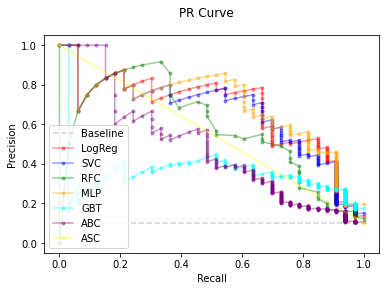

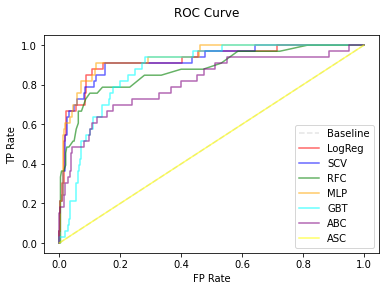

In [16]:
average_precision_lgrg = average_precision_score(y_test_og, lr_probs_lgrg)
average_precision_svc = average_precision_score(y_test_og, lr_probs_svc)
average_precision_rfc = average_precision_score(y_test_og, lr_probs_rfc)
average_precision_mlp = average_precision_score(y_test_og, lr_probs_mlp)
average_precision_gbt = average_precision_score(y_test_og, lr_probs_gbt)
average_precision_abc = average_precision_score(y_test_og, lr_probs_abc)
average_precision_asc = average_precision_score(y_test_og, lr_probs_asc)

auc_lgrg = roc_auc_score(y_test_og, lr_probs_lgrg)
auc_svc = roc_auc_score(y_test_og, lr_probs_svc)
auc_rfc = roc_auc_score(y_test_og, lr_probs_rfc)
auc_mlp = roc_auc_score(y_test_og, lr_probs_mlp)
auc_gbt = roc_auc_score(y_test_og, lr_probs_gbt)
auc_abc = roc_auc_score(y_test_og, lr_probs_abc)
auc_asc = roc_auc_score(y_test_og, lr_probs_asc)

no_skill_pr = y_test_og.sum(axis =0) / len(y_test_og)
no_skill_auc = roc_auc_score(y_test_og, ns_probs)

precision_lgrg, recall_lgrg, thresholds_lgrg = precision_recall_curve(y_test_og, lr_probs_lgrg)
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(y_test_og, lr_probs_svc)
precision_rfc, recall_rfc, thresholds_rfc = precision_recall_curve(y_test_og, lr_probs_rfc)
precision_mlp, recall_mlp, thresholds_mlp = precision_recall_curve(y_test_og, lr_probs_mlp)
precision_gbt, recall_gbt, thresholds_gbt = precision_recall_curve(y_test_og, lr_probs_gbt)
precision_abc, recall_abc, thresholds_abc = precision_recall_curve(y_test_og, lr_probs_abc)
precision_asc, recall_asc, thresholds_asc = precision_recall_curve(y_test_og, lr_probs_asc)


no_skill_fpr, no_skill_tpr, _ = roc_curve(y_test_og, ns_probs)
fpr_lgrg, tpr_lgrg, _ = roc_curve(y_test_og, lr_probs_lgrg)
fpr_svc, tpr_svc, _ = roc_curve(y_test_og, lr_probs_svc)
fpr_rfc, tpr_rfc, _ = roc_curve(y_test_og, lr_probs_rfc)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_og, lr_probs_mlp)
fpr_gbt, tpr_gbt, _ = roc_curve(y_test_og, lr_probs_gbt)
fpr_abc, tpr_abc, _ = roc_curve(y_test_og, lr_probs_abc)
fpr_asc, tpr_asc, _ = roc_curve(y_test_og, lr_probs_asc)

print("Average Precision")
print("LGRG : ",(average_precision_lgrg))
print("SVC  : ",(average_precision_svc))
print("RFC  : ",(average_precision_rfc))
print("MLP  : ",(average_precision_mlp))
print("GBT  : ",(average_precision_gbt))
print("ABC  : ",(average_precision_abc))
print("ASC  : ",(average_precision_asc))

ns_auc = roc_auc_score(y_test_og, ns_probs)

print("\n\nROC AUC")
print("LGRG : ",(auc_lgrg))
print("SVC  : ",(auc_svc))
print("RFC  : ",(auc_rfc))
print("MLP  : ",(auc_mlp))
print("GBT  : ",(auc_gbt))
print("ABC  : ",(auc_abc))
print("ABC  : ",(auc_asc))

fig = plt.figure(1)
fig.suptitle('PR Curve')
ax = fig.add_subplot(111)
plt.plot([0, 1], [no_skill_pr, no_skill_pr], linestyle='--', label='Baseline', color = "lightgrey")
plt.plot(recall_lgrg, precision_lgrg, marker='.', label='LogReg',color = "red", alpha = 0.4)
plt.plot(recall_svc, precision_svc, marker='.', label='SVC',color = "blue", alpha = 0.4)
plt.plot(recall_rfc, precision_rfc, marker='.', label='RFC',color = "green", alpha = 0.4)
plt.plot(recall_mlp, precision_mlp, marker='.', label='MLP',color = "orange", alpha = 0.4)
plt.plot(recall_gbt, precision_gbt, marker='.', label='GBT',color = "cyan", alpha = 0.4)
plt.plot(recall_abc, precision_abc, marker='.', label='ABC',color = "purple", alpha = 0.4)
plt.plot(recall_asc, precision_asc, marker='.', label='ASC',color = "yellow", alpha = 0.4)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

fig = plt.figure(2)
fig.suptitle('ROC Curve')
ax = fig.add_subplot(111)
plt.plot(no_skill_fpr, no_skill_tpr, linestyle='--', label='Baseline', color = "lightgrey", alpha = 0.6)
plt.plot(fpr_lgrg, tpr_lgrg, marker='', label='LogReg', color = "red", alpha = 0.6)
plt.plot(fpr_svc, tpr_svc, marker='', label='SCV', color = "blue", alpha = 0.6)
plt.plot(fpr_rfc, tpr_rfc, marker='', label='RFC', color = "green", alpha = 0.6)
plt.plot(fpr_mlp, tpr_mlp, marker='', label='MLP', color = "orange", alpha = 0.6)
plt.plot(fpr_gbt, tpr_gbt, marker='', label='GBT', color = "cyan", alpha = 0.6)
plt.plot(fpr_abc, tpr_abc, marker='', label='ABC', color = "purple", alpha = 0.6)
plt.plot(fpr_asc, tpr_asc, marker='', label='ASC', color = "yellow", alpha = 0.6)
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.legend()

## feature importance

In [172]:
importance_lgrg = mod_lgrg.coef_[0]

fimp_lgrg = pd.concat((pd.DataFrame(x_full_og.columns).rename(columns={0:"feature"}),
                       pd.DataFrame(importance_lgrg).rename(columns={0:"importance"})),axis=1)
fimp_lgrg["absolute importance"] = np.abs(pd.to_numeric(fimp_lgrg["importance"]))

fimp_lgrg.sort_values(by=["absolute importance"], ascending=False).drop("absolute importance",axis=1).head(5)

,feature,importance
707,b23_V26,-0.516516
373,b13_V2,0.393915
417,b14_V15,0.383700
948,b31_V19,0.371765
1502,b49_V15,-0.363095


In [44]:
importance_svc = mod_svc.coef_[0]

fimp_svc = pd.concat((pd.DataFrame(x_full_og.columns).rename(columns={0:"feature"}),
                      pd.DataFrame(importance_svc).rename(columns={0:"importance"})),axis=1)
fimp_svc["absolute importance"] = np.abs(pd.to_numeric(fimp_svc["importance"]))

fimp_svc.sort_values(by=["absolute importance"], ascending=False).drop("absolute importance",axis=1).head(5)


,feature,importance
707,b23_V26,-0.142461
1502,b49_V15,-0.139375
373,b13_V2,0.126292
417,b14_V15,0.124348
948,b31_V19,0.120639


In [47]:
importance_rfc = mod_rfc.feature_importances_

fimp_rfc = pd.concat((pd.DataFrame(x_full_og.columns).rename(columns={0:"feature"}), 
                      pd.DataFrame(importance_rfc).rename(columns={0:"importance"})),axis=1)

fimp_rfc.sort_values(by=["importance"], ascending=False).head(5)

,feature,importance
953,b31_V24,0.019164
933,b31_V4,0.012080
1512,b49_V25,0.010000
1024,b34_V2,0.007991
1500,b49_V13,0.006599


In [48]:
def get_feature_importance(j, n, y_test, x_test, test_pred, model):
    s = f1_score(y_test, test_pred) # baseline score
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(x_test.to_numpy().shape[0]))
        X_test_ = x_test.to_numpy().copy()
        X_test_[:, j] = x_test.to_numpy()[perm, j]
        y_pred_ = model.predict(X_test_)
        s_ij = f1_score(y_test, y_pred_)
        total += s_ij
    return s - total / n

In [49]:
# Feature importances
n = 10
f_mlp = []

for j in tqdm(range(x_test_og.shape[1])): # n=50 : time=11min
    f_j = get_feature_importance(j, n, y_test_og, x_test_og, pred_test_mlp, mod_mlp)
    f_mlp.append(f_j)

100%|██████████| 1519/1519 [02:37<00:00,  9.65it/s]


In [295]:
fimp_mlp = pd.DataFrame({'feature': list(x_test_og.columns),'importance': f_mlp})

fimp_mlp.sort_values(by=["importance"], ascending=False).head(5)

,feature,importance
1412,b46_V18,0.018665
736,b24_V24,0.018456
290,b10_V12,0.017757
695,b23_V14,0.017684
1474,b48_V18,0.017503


In [294]:
importance_gbt = mod_gbt.feature_importances_

fimp_gbt = pd.concat((pd.DataFrame(x_full_og.columns).rename(columns={0:"feature"}), 
                      pd.DataFrame(importance_gbt).rename(columns={0:"importance"})),axis=1)

fimp_gbt.sort_values(by=["importance"], ascending=False).head(5)

,feature,importance
1510,b49_V23,0.067246
816,b27_V11,0.031722
735,b24_V23,0.021726
1033,b34_V11,0.021085
759,b25_V16,0.018986


In [317]:
importance_abc = mod_abc.feature_importances_

fimp_abc = pd.concat((pd.DataFrame(x_full_og.columns).rename(columns={0:"feature"}), 
                      pd.DataFrame(importance_abc).rename(columns={0:"importance"})),axis=1)

fimp_abc.sort_values(by=["importance"], ascending=False).head(5)

,feature,importance
198,b7_V13,0.02
1459,b48_V3,0.02
456,b15_V23,0.02
1449,b47_V24,0.02
333,b11_V24,0.02


## derived feature importance comparison

In [165]:
# Feature importances
n = 50 # n=50 : time=7min
f_lgrg = []

for j in tqdm(range(x_test_og.shape[1])):
    f_j = get_feature_importance(j, n, y_test_og, x_test_og, pred_test_lgrg, mod_lgrg)
    f_lgrg.append(f_j)

100%|██████████| 1519/1519 [07:04<00:00,  3.58it/s]


In [194]:
fimp_lgrg_der = pd.DataFrame({'feature': list(x_test_og.columns),'importance_der': f_lgrg})
fimp_lgrg_der.sort_values(by=["importance_der"], ascending=False).head(5)

,feature,importance_der
44,b2_V14,0.063526
373,b13_V2,0.061809
789,b26_V15,0.059562
1133,b37_V18,0.053813
1190,b39_V13,0.047500


<AxesSubplot:xlabel='beta importance', ylabel='derived importance'>

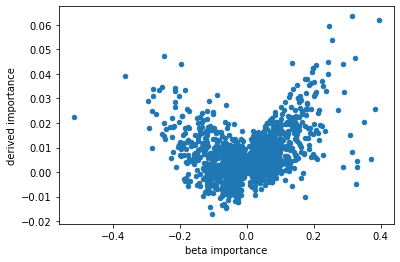

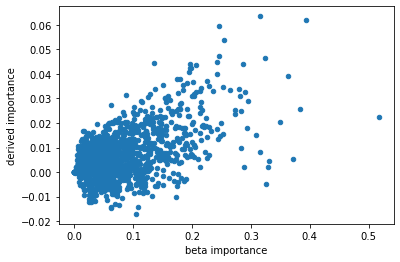

In [214]:
df_help = pd.DataFrame({'rank': range(0,1519), 'beta importance': list(fimp_lgrg.importance),'derived importance': list(fimp_lgrg_der.importance_der)})
df_help.plot.scatter('beta importance', 'derived importance')#,s = "rank")#,c= "rank")

df_help = pd.DataFrame({'rank': range(0,1519), 'beta importance': list(abs(fimp_lgrg.importance)),'derived importance': list(fimp_lgrg_der.importance_der)})
df_help.plot.scatter('beta importance', 'derived importance')#,s = "rank")#,c= "rank")

In [226]:
comb_df  = pd.concat([fimp_lgrg, fimp_lgrg_der], axis=1).drop(["feature","importance"],axis=1)
comb_df.corr()
# comb_df.nlargest(10,'absolute importance').corr()

,absolute importance,importance_der
absolute importance,1.000000,0.543095
importance_der,0.543095,1.000000


In [258]:
# Feature importances
n = 6 # n=3 : time=15min - n=6 : t=30min
f_svc = []

for j in tqdm(range(x_test_og.shape[1])):
    f_j = get_feature_importance(j, n, y_test_og, x_test_og, pred_test_svc, mod_svc)
    f_svc.append(f_j)

100%|██████████| 1519/1519 [30:56<00:00,  1.22s/it]


In [261]:
fimp_svc_der = pd.DataFrame({'feature': list(x_test_og.columns),'importance_der': f_svc})
fimp_svc_der.sort_values(by=["importance_der"], ascending=False).head(5)

,feature,importance_der
521,b17_V26,0.033467
531,b18_V5,0.028048
943,b31_V14,0.022541
853,b28_V17,0.021023
373,b13_V2,0.020685


<AxesSubplot:xlabel='beta importance', ylabel='derived importance'>

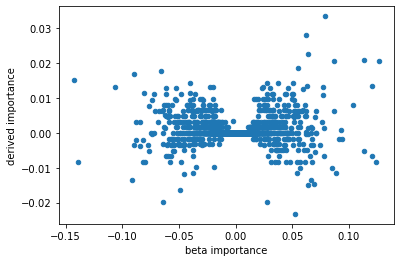

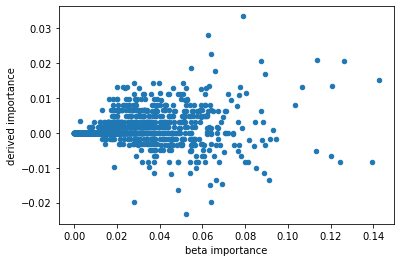

In [262]:
df_help = pd.DataFrame({'rank': range(0,1519), 'beta importance': list(fimp_svc.importance),'derived importance': list(fimp_svc_der.importance_der)})
df_help.plot.scatter('beta importance', 'derived importance')#,s = "rank")#,c= "rank")

df_help = pd.DataFrame({'rank': range(0,1519), 'beta importance': list(abs(fimp_svc.importance)),'derived importance': list(fimp_svc_der.importance_der)})
df_help.plot.scatter('beta importance', 'derived importance')#,s = "rank")#,c= "rank")

In [237]:
comb_df  = pd.concat([fimp_svc, fimp_svc_der], axis=1).drop(["feature","importance"],axis=1)
comb_df.corr()
# comb_df.nlargest(20,'abs importance').corr()

,abs importance,importance_der
abs importance,1.000000,0.195015
importance_der,0.195015,1.000000


In [263]:
# Feature importances
n = 60 # n=30 : time=6.5min n=60:t=14
f_mlp = []

for j in tqdm(range(x_test_og.shape[1])):
    f_j = get_feature_importance(j, n, y_test_og, x_test_og, pred_test_mlp, mod_mlp)
    f_mlp.append(f_j)

100%|██████████| 1519/1519 [14:09<00:00,  1.79it/s]


In [267]:
fimp_mlp_der = pd.DataFrame({'feature': list(x_test_og.columns),'importance_der': f_mlp})
fimp_mlp_der.sort_values(by=["importance_der"], ascending=False).head(5)

,feature,importance_der
1412,b46_V18,0.018665
736,b24_V24,0.018456
290,b10_V12,0.017757
695,b23_V14,0.017684
1474,b48_V18,0.017503


<AxesSubplot:xlabel='feature importance', ylabel='derived importance'>

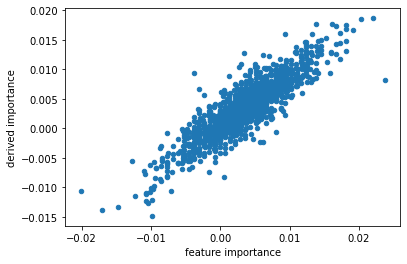

In [268]:
df_help = pd.DataFrame({'rank': range(0,1519), 'feature importance': list(fimp_mlp.importance),'derived importance': list(fimp_mlp_der.importance_der)})
df_help.plot.scatter('feature importance', 'derived importance')#,s = "rank")#,c= "rank")

In [269]:
comb_df  = pd.concat([fimp_mlp, fimp_mlp_der], axis=1).drop(["feature"],axis=1)
comb_df.corr()
#comb_df.nlargest(30,'importance').corr()

,importance,importance_der
importance,1.00000,0.88378
importance_der,0.88378,1.00000
